In [1]:
# ARIMA Model
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from datetime import datetime
from math import sqrt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

In [2]:
fd_path = 'D:/Time_Series_Research/new_data/DJI/DJI_2008.csv'
df = pd.read_csv(fd_path, sep=',', header=0)

In [3]:
df.dtypes

Date            object
Close          float64
Volume           int64
MA_5           float64
Ma20           float64
BBands_up      float64
BBands_down    float64
RSI            float64
EMA_12         float64
EMA_26         float64
DIF            float64
DEM            float64
OSC            float64
RDP            float64
BIAS6          float64
BIAS12         float64
BIas24         float64
psy12          float64
psy24          float64
W%R            float64
%K             float64
%D             float64
PROC           float64
MO             float64
LAG            float64
dtype: object

In [4]:
str_in = input("Whic feature you want to choose？")
year = eval(input("Input your year?"))

Whic feature you want to choose？all
Input your year?2008


In [5]:
if str_in.strip().lower() == "all":
    new_df = df
else:
    choose_feature = [int(n) for n in str_in.split()]
    new_df = df[['Date', 'Close']]
    for i in range(0,len(choose_feature)):
        new_df = pd.concat([new_df, df.iloc[:, choose_feature[i]]], axis=1)

print(new_df.columns,'\n')

date_array = pd.to_datetime(new_df['Date'])
print("Number of rows and columns:", new_df.shape,'\n')

split_no = 0
while date_array.iloc[split_no] < datetime(year, 11,1, 0, 0):
    split_no +=1
print(split_no,'\n')

new_df.drop(['Date'], axis=1, inplace=True)
new_df.head(5)

# sc_df = MinMaxScaler(feature_range = (0, 1))
# new_df = sc_df.fit_transform(new_df)

new_df = new_df.values
train_set = new_df[:split_no, :]
test_set = new_df[split_no:, :]

train_data = train_set[:,1:]
train_label = train_set[:,0]
test_data = test_set[:,1:]
test_label = test_set[:,0]

Index(['Date', 'Close', 'Volume', 'MA_5', 'Ma20', 'BBands_up', 'BBands_down',
       'RSI', 'EMA_12', 'EMA_26', 'DIF', 'DEM', 'OSC', 'RDP', 'BIAS6',
       'BIAS12', 'BIas24', 'psy12', 'psy24', 'W%R', '%K', '%D', 'PROC', 'MO',
       'LAG'],
      dtype='object') 

Number of rows and columns: (252, 25) 

212 



In [6]:
# train_label = train_label.reshape(train_label.shape[0],1)
# test_label = test_label.reshape(test_label.shape[0],1)
print(f"Train_data shape : {train_data.shape}\n"
      f"Train_label shape :{train_label.shape}\n"
      f"Test_data shape :{test_data.shape}\n"
      f"Test_label shape :{test_label.shape}\n")

Train_data shape : (212, 23)
Train_label shape :(212,)
Test_data shape :(40, 23)
Test_label shape :(40,)



In [7]:
#原始函數
df_close = df['Close']
df_close.index = date_array
df_close.head()

Date
2008-01-02    13043.959961
2008-01-03    13056.719727
2008-01-04    12800.179688
2008-01-07    12827.490234
2008-01-08    12589.070313
Name: Close, dtype: float64

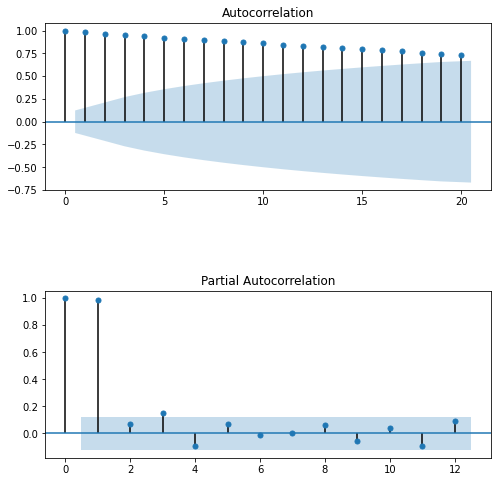

In [8]:
#p 和 q 階數確定，ACF和PACF
flg , ax = plt.subplots(2,1,sharex = False ,sharey = False)
flg.set_size_inches(8, 8)
flg.subplots_adjust(hspace=0.6, wspace=0.4)
flg= plot_acf(df_close, lags= 20 ,ax=ax[0])
flg= plot_pacf(df_close, lags= 12 ,ax=ax[1])
plt.show()

In [9]:
sm.tsa.stattools.adfuller(df_close)[:2]

(-0.27922894654179636, 0.9283950521204438)

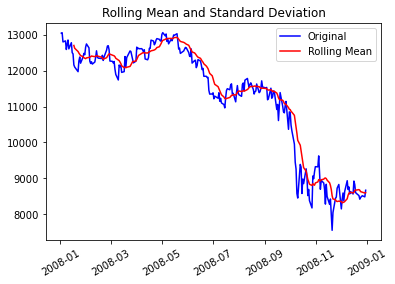

Results of dickey fuller test
Test Statistics                 -0.279229
p-value                          0.928395
No. of lags used                 2.000000
Number of observations used    249.000000
critical value (1%)             -3.456888
critical value (5%)             -2.873219
critical value (10%)            -2.572994
dtype: float64


In [10]:
# Test for staionarity
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    # Plot rolling statistics:
    plt.plot(date_array,timeseries, color='blue', label='Original')
    plt.plot(date_array,rolmean, color='red', label='Rolling Mean')
#     plt.plot(date_array,rolstd, color='black', label='Rolling Std')
    plt.xticks(rotation=30)
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    # Test for staionarity
    print("Results of dickey fuller test")
    adft = adfuller(timeseries, autolag='AIC')
    # output for dft will give us without defining what the values are.
    # hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],
                       index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, values in adft[4].items():
        output['critical value (%s)' % key] = values
    print(output)


test_stationarity(df_close)

In [11]:
#一階方差、二階方差
diff1 = df_close.diff(1)[1:]
diff2 = diff1.diff(1)[1:]

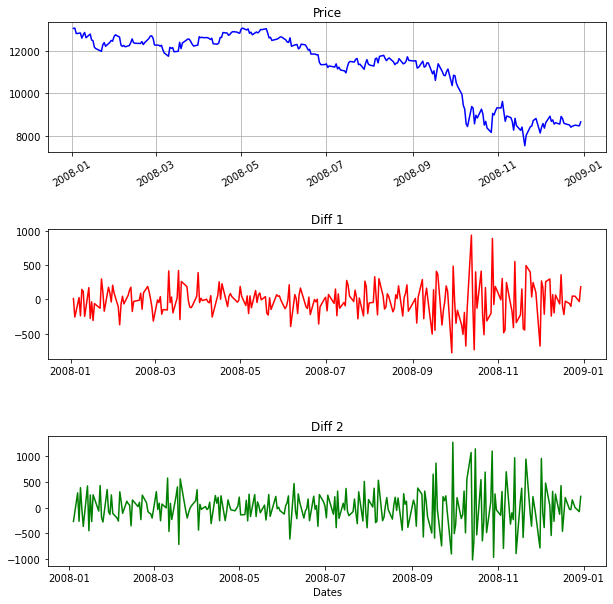

In [12]:
#將序列平穩(差分法確定d)
flg ,ax= plt.subplots(3,1,sharex=False,sharey=False)
flg.set_size_inches(10,10)
flg.subplots_adjust(hspace=0.6, wspace=0.4)
ax[0].plot(date_array,df_close,'b-',label = 'price')
ax[0].grid(True)
ax[0].tick_params(axis='x',rotation = 30)
ax[0].set_title("Price")
# ax[0].legend(loc='best')
ax[1].plot(diff1, 'r-')
ax[1].set_title("Diff 1")
ax[2].plot(diff2, 'g-')
ax[2].set_title("Diff 2")
plt.xlabel('Dates')
plt.show()

In [13]:
print(sm.tsa.stattools.adfuller(diff1)[:2])
print(sm.tsa.stattools.adfuller(diff2)[:2])

(-14.751058107483201, 2.48464624850075e-27)
(-7.245521605839564, 1.8366245896162292e-10)


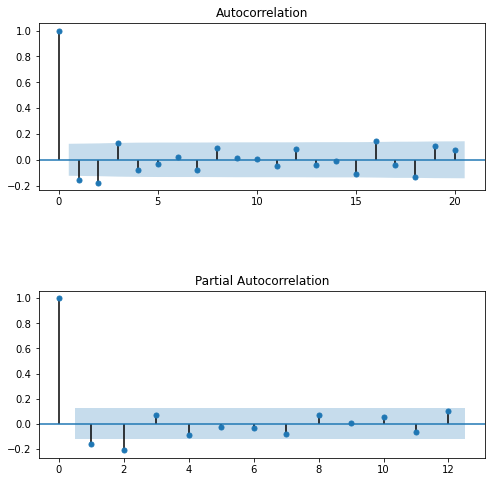

In [14]:
#一階方差，ACF和PACF
flg , ax = plt.subplots(2,1,sharex = False ,sharey = False)
flg.set_size_inches(8, 8)
flg.subplots_adjust(hspace=0.6, wspace=0.4)
flg= plot_acf(diff1, lags= 20 ,ax=ax[0])
flg= plot_pacf(diff1, lags= 12 ,ax=ax[1])
plt.show()

# ARIMA TEST MODEL 1

from pmdarima.arima import auto_arima

model = auto_arima(train_label,exogenous=train_data,start_p=1,d=1,start_q=0)model = auto_arima(train_label,start_p=1,d=1,start_q=0)

model.fit(test_label)

model.summary()

preds, conf_int = model.predict(n_periods=test_label.shape[0], return_conf_int=True)

new_test_label = np.array(preds)
new_test_label = new_test_label.reshape(new_test_label.shape[0],1)
new_test_set = np.concatenate([test_data,new_test_label],axis = 1)
new_test_set = sc_df.inverse_transform(new_test_set)
new_test_label = new_test_set[:,new_test_set.shape[1]-1]


test_label = df.Close[split_no:]

testScore = sqrt(mean_squared_error(test_label, new_test_label))
print('Test RMSE: %.4f' % (testScore))

mape = sum(np.abs((test_label - new_test_label)/test_label))/split_no*100
print('Test MAPE: %.4f' % (mape))

flg ,ax = plt.subplots(1,1)
plt.plot(date_array[split_no:], test_label, color ='red', label ='Real Stock Price')
plt.plot(date_array[split_no:], new_test_label, color ='blue', label ='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.xticks(rotation = 30)
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# ARIMA TEST MODEL 2

In [18]:
arima010 =  sm.tsa.arima.ARIMA(endog = train_label,exog = train_data,order = (0,1,0))

In [20]:
model_fit = arima010.fit()

C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [21]:
x = test_data[0, :]  
x = x.reshape(1,x.shape[0])  
x.shape

(1, 23)

In [22]:
forecast = model_fit.forecast(exog = x)

In [23]:
forecast[0]

9319.830078000059

In [24]:
test_label[0]

array([9319.830078])

In [15]:
new_test_label = []
all_length = len(new_df)
n = split_no

In [16]:
for i in range(0, all_length - split_no):
    print()
    print(f"No. {i + 1} Model training! Total number of times {all_length - split_no}!\n")
    print(fd_path + "\n")
    #training model
    a = train_data 
    b = train_label

    arima010 = ARIMA(endog = train_label,exog = train_data,order = (0,1,0))
    model_fit = arima010.fit(disp = 0)

    # fit network
    #predicting
    x = test_data[i, :]
    x = x.reshape(1,x.shape[0])
    forecast = model_fit.forecast(exog = x)
    # new_test_label = np.concatenate([new_test_label,testPredict],axis = 0)
    new_test_label.append(forecast[0])

    #add next data
    y = test_data[i, :]
    y = y.reshape(1, y.shape[0])
    train_data = np.concatenate([train_data, y], axis=0)
    z = test_label[i].reshape(1, )
    train_label = np.concatenate([train_label, z], axis=0)


No. 1 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv




C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


No. 2 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv


No. 3 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv



C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



No. 4 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv


No. 5 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv


No. 6 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv



C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params availabl


No. 7 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv



C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



No. 8 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv



C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



No. 9 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv


No. 10 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv



C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)



No. 11 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv



C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



No. 12 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv



C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



No. 13 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv


No. 14 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv



C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



No. 15 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv


No. 16 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv



C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



No. 17 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv



C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



No. 18 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv


No. 19 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv



C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



No. 20 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv


No. 21 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv



C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)



No. 22 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv



C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



No. 23 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv


No. 24 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv



C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



No. 25 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv


No. 26 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv



C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



No. 27 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv


No. 28 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv



C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



No. 29 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv


No. 30 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv



C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



No. 31 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv



C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



No. 32 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv


No. 33 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv



C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)



No. 34 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv



C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



No. 35 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv


No. 36 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv


No. 37 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv



C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params availabl


No. 38 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv


No. 39 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv



C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\cooke\.conda\envs\tfgpu\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)



No. 40 Model training! Total number of times 40!

D:/Time_Series_Research/new_data/DJI/DJI_2008.csv



Test RMSE: 0.0000
Test MAPE: 0.0000


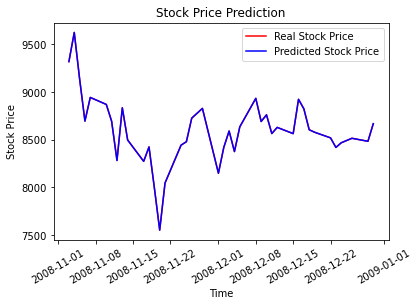

In [17]:
new_test_label = np.array(new_test_label)

test_label = test_label.reshape(test_label.shape[0],1)

testScore = sqrt(mean_squared_error(test_label, new_test_label))
print('Test RMSE: %.4f' % (testScore))

mape = sum(np.abs((test_label - new_test_label)/test_label))/split_no*100
print('Test MAPE: %.4f' % (mape))

flg ,ax = plt.subplots(1,1)
plt.plot(date_array[split_no:], test_label, color ='red', label ='Real Stock Price')
plt.plot(date_array[split_no:], new_test_label, color ='blue', label ='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.xticks(rotation = 30)
plt.ylabel('Stock Price')
plt.legend()
plt.show()
